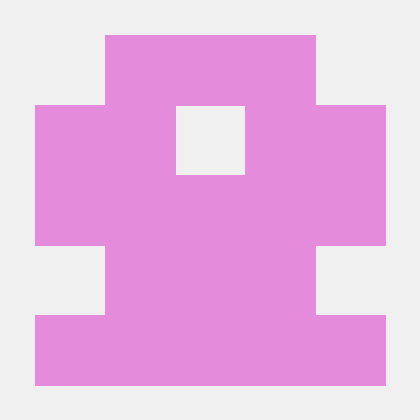

# Image Similarity Search

In this tutorial notebook, we will walk you through how to create an image similarity search backend service. You will learn how to use the pre-trained embedding model called `squeezenet` from `torchvision` to transform image data into vector embeddings. You will build an index with Pinecone to store these vector embeddings. Lastly, you will learn how to send a new image as query, and retrieve similar images in the index.



The structure of this notebook is as follows:

1. Install dependencies and set up Pinecone.
1. Download an image dataset (e.g., TinyImageNet).
1. Download a pre-trained computer vision (CV) model (e.g. squeezenet).
1. Using the CV model, convert images to their vector embeddings.
1. Create a Pinecone vector index, which serves as the backend service.
1. Upload and index your image vectors.
1. Perform image similarity search and review the results.
1. Delete the index.

## Prerequisites

Install dependencies.

In [1]:
!pip install -qU pinecone-client imgaug==0.2.5
!pip install -q torchvision pandas matplotlib==3.1.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.3 which is incompatible.


Set up Pinecone. Get your Pinecone API key [here](https://www.pinecone.io/start/).

In [2]:
import pinecone
import os

api_key = os.getenv("PINECONE_API_KEY") or "YOUR_API_KEY"
pinecone.init(api_key=api_key, environment='us-west1-gcp')

## Data preparation


In this example, we will use the Tiny ImageNet dataset http://cs231n.stanford.edu/, which has 100,000 training images cross 200 classes. Each class has 500 training images.

In [ ]:
import requests, os, zipfile

DATA_DIR = "tmp"
IMAGENET_DIR = f"{DATA_DIR}/tiny-imagenet-200"
IMAGENET_ZIP = f"{DATA_DIR}/tiny-imagenet-200.zip"
IMAGENET_URL = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"


def download_data():
    os.makedirs(DATA_DIR, exist_ok=True)

    if not os.path.exists(IMAGENET_DIR):
        if not os.path.exists(IMAGENET_ZIP):
            r = requests.get(IMAGENET_URL)  # create HTTP response object
            with open(IMAGENET_ZIP, "wb") as f:
                f.write(r.content)

        with zipfile.ZipFile(IMAGENET_ZIP, "r") as zip_ref:
            zip_ref.extractall(DATA_DIR)


download_data()

`torchvision` is a popular library from PyTorch(`torch`) that provides convenient functions for loading and transforming images. Here we use `torchvision` to select images that belong to a random subset of image classes.

In [ ]:
from torchvision import datasets
import random

random_seed = 123
random.seed(random_seed)

# Select a random sample of image classes
image_classes = set(random.sample(range(200), 5))

# Get the corresponding image file names
image_file_names = [
    file_name
    for file_name, label in datasets.ImageFolder(f"{IMAGENET_DIR}/train").imgs
    if label in image_classes
]

Let's look at some of selected images. We'll write two utility functions to show the images, which will also be useful later.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image


def show_images_horizontally(file_names):
    m = len(file_names)
    fig, ax = plt.subplots(1, m)
    fig.set_figwidth(1.5 * m)
    for a, f in zip(ax, file_names):
        a.imshow(Image.open(f))
        a.axis("off")
    plt.show()


def show_image(file_name):
    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(1.3)
    ax.imshow(Image.open(file_name))
    ax.axis("off")

In [ ]:
for i in range(5):
    show_images_horizontally(random.sample(image_file_names, 10))

## Convert images to embeddings using a pre-trained neural network model

[Vector embeddings](https://www.pinecone.io/learn/what-are-vectors-embeddings/) for images are representations of images as high dimensional vectors. 

A typical image file consists of values of pixel intensities in three spectra: red, green, and blue. A naïve way of converting an image file to a vector is by "flattening" the image file--that is, arranging all pixel value in one row. Sadly this is practically useless for most machine learning applications.

A much better way of creating a vector representation of an image is to apply a computer vision (CV) model to the image. The output of the CV model is a vector embedding of the image optimized for assessing the image similarity. In other words, the CV model maps similar images to vectors that are close to each other, and dissimilar images to vectors that are far apart. By converting images to vector embeddings, we can simplify the problem of image similarity search to that of vector proximity search.

In practice, we don't always have to train a new CV model. In this example, we will use a pre-trained model from `torchvision` called `squeezenet` to convert the images. Feel free to experiment with other models provided by `torchvision` to see which model best fits your application. See `torchvision` [examples page](https://pytorch.org/vision/0.8/models.html).


In [ ]:
from torchvision import transforms as ts
import torchvision.models as models


class ImageEmbedder:
    def __init__(self):
        self.normalize = ts.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
        # see sss0.8/models.html for many more model options
        self.model = models.squeezenet1_0(pretrained=True, progress=False)  # squeezenet

    def embed(self, image_file_name):
        image = Image.open(image_file_name).convert("RGB")
        image = ts.Resize(256)(image)
        image = ts.CenterCrop(224)(image)
        tensor = ts.ToTensor()(image)
        tensor = self.normalize(tensor).reshape(1, 3, 224, 224)
        vector = self.model(tensor).cpu().detach().numpy().flatten()
        return vector


image_embedder = ImageEmbedder()

Once we have the image embedder class, we can use it to convert image files to vector embeddings.

In [ ]:
from tqdm import tqdm
import pandas as pd

df = pd.DataFrame()
df["image_file_name"] = image_file_names
df["embedding_id"] = [
    file_name.split(IMAGENET_DIR)[-1] for file_name in image_file_names
]
df["embedding"] = [
    image_embedder.embed(file_name).tolist()
    for file_name in tqdm(image_file_names, miniters=int(len(image_file_names) / 100))
]
df = df.sample(frac=1)  # shuffle the images

In [ ]:
print(df.head(2))

Split the data into the items dataset and the queries dataset. Because the data is already shuffled, we can directly split the data.

In [ ]:
cutoff = int(len(df) * 0.95)
item_df, query_df = df[:cutoff], df[cutoff:]
(item_df.shape, query_df.shape)

## Create a Pinecone vector index service

Now that we have our vector embeddings we can create our Pinecone service and upload the data to it.

Below we create a Pinecone index. Here we use two arguments: 
- `metric="euclidean"` means the vector search will use euclidean distance as the measure of similarity.
- `shards=1` means the service will run on a single node. Since we only index at most 100k vectors in 1000 dimensions, a single shard is more than enough. If you have more than 1M vectors, you should increase the number of shards. Refer to the [documentation](https://docs.beta.pinecone.io/en/latest/python_client/graph.html#pinecone.graph.IndexGraph) for guidelines on how to choose the number of shards.

In [ ]:
# Choosing an arbitrary name for my index
index_name = "simple-pytorch-image-search"

# Checking whether the index already exists.
if index_name not in pinecone.list_indexes():
    pinecone.create_index(index_name, dimension=1000, metric="euclidean")

Now that the index is created, we can upload vectorized images. To do that, we connect to the index. You only need to do this once.

In [ ]:
index = pinecone.Index(index_name=index_name)

`upsert` will upload, add, and index items into your remote vector similarity search service. If an item with that ID already exists it will be overwritten with the new provided value. 




In [ ]:
import itertools

def chunks(iterable, batch_size=100):
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [ ]:
for batch in chunks(zip(item_df.embedding_id, item_df.embedding), 50):
    index.upsert(vectors=batch)

## Querying 

Let's test dataset as test queries.

In [ ]:
import time


start = time.perf_counter()
total_res = list()
for batch in chunks(query_df.embedding,10):
    res = index.query(batch, top_k=10)  # issuing queries
    total_res += [res.matches for res in res.results]

end = time.perf_counter()
print("Run this test on a fast network to get the best performance.")
# print(f"Service throughput is {int(len(query_df)/(end-start))} queries/second.")

In [ ]:
len(total_res)

Now that we have our results, we can look at them.

In [ ]:
for i in range(30, 40):
    print(f"Query {i+1} and search results")
    ids = [match.id for match in total_res[i]]
    show_image(query_df.image_file_name.iloc[i])
    show_images_horizontally(
        [IMAGENET_DIR + embedding_id for embedding_id in ids]
    )

    print("-" * 80)

As is shown above, image similarity search works relatively well with the pre-trained CV model: when we query with images that are not in the index, most similarity seaches return images from the same class as the query images.

## Wrap up

You can use `pinecone.delete_index` to delete the index and free all resources dedicated to it. Once an index is deleted all resources need to be recreated. We suggest that you only delete an index if no application is using it.

In [ ]:
pinecone.delete_index(index_name)